In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import Luna

%matplotlib inline 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Using TensorFlow backend.


In [2]:
# Dataset directory
DATASET_DIR = "dataset/prepared_data"

# Inference Configuration
config = Luna.LunaInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

In [5]:
# Load validation dataset
dataset = Luna.LunaDataset()
dataset.load_nodule(DATASET_DIR, "test")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 710
Classes: ['BG', 'nodule']


In [6]:
# Create model in inference mode
LOGS_DIR = "logs"
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [7]:
# Path to a specific weights file
weights_path = "logs/nucleus20200529T1534/mask_rcnn_nucleus_0040.h5"

# Or, load the last model you trained
#weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  logs/nucleus20200529T1534/mask_rcnn_nucleus_0040.h5






Re-starting from epoch 40


199
image ID: nodule.246 (199) 246
Original image shape:  [512 512   3]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  249.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  249.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  242.00000  max:  952.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.500
Shapes  (1, 4) (5, 4)
(5, 4) (5, 4)
284411.2


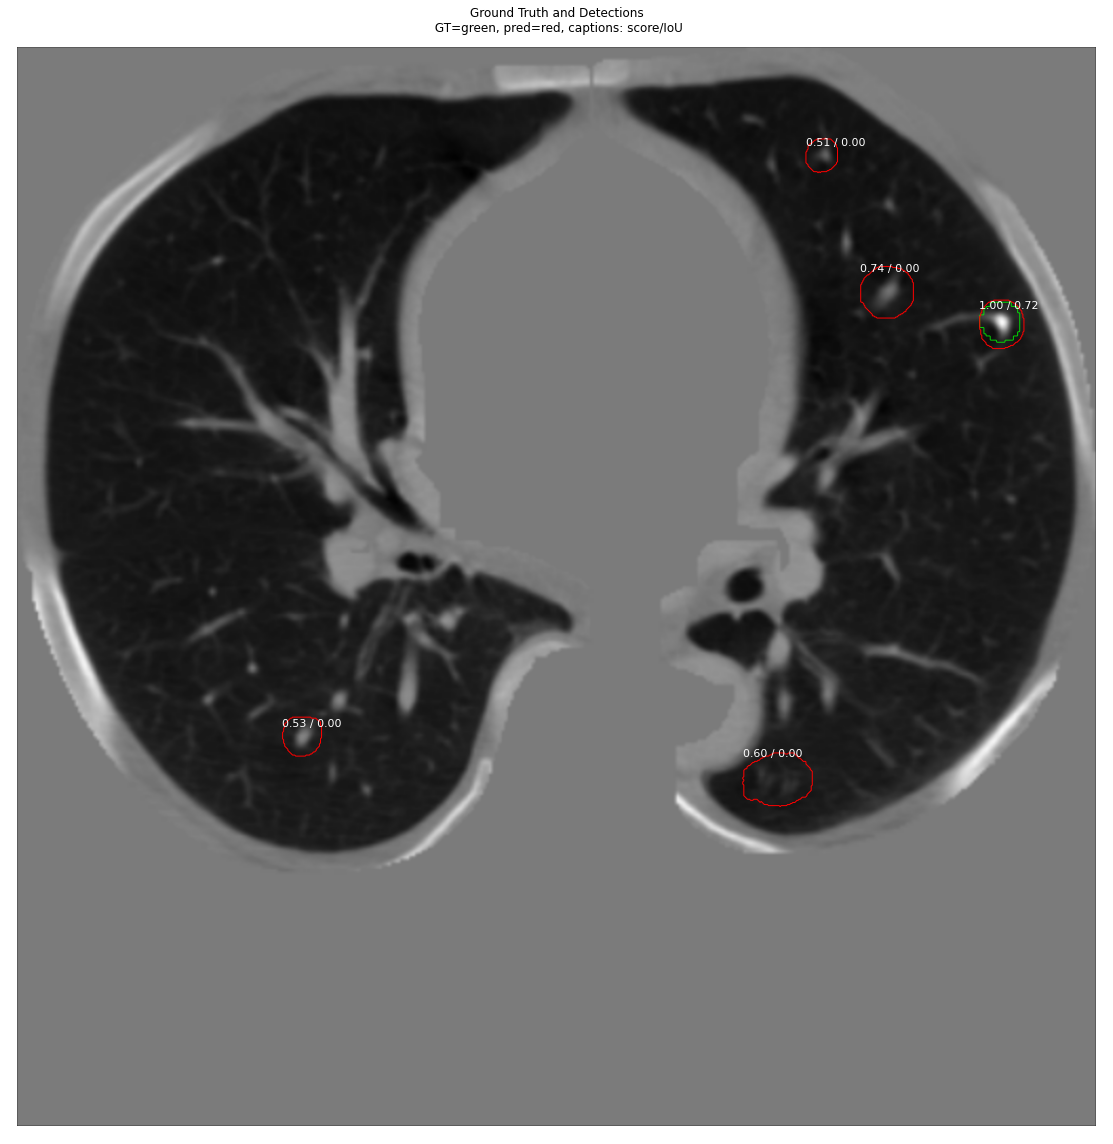

In [8]:
image_id = random.choice(dataset.image_ids)
print(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)
#print(gt_mask.shape,r['masks'].shape)
#import cv2
#cv2.imwrite("Mask.png", gt_mask*255.0) 
#cv2.imwrite(filename, img) 
from sklearn.metrics import mean_squared_error
print("Shapes ",gt_bbox.shape,r['rois'].shape)
#print(gt_bbox)
#print(r['rois'])

if gt_bbox.shape[0]>r['rois'].shape[0]:
    y_pred = np.zeros((gt_bbox.shape[0],4))
    y_pred[0:r['rois'].shape[0],:] = r['rois']
    y_true = gt_bbox
elif gt_bbox.shape[0]<r['rois'].shape[0]:
    y_true = np.zeros((r['rois'].shape[0],4))
    y_true[0:gt_bbox.shape[0],:] = gt_bbox
    y_pred = r['rois']
else:
    y_pred = r['rois']
    y_true = gt_bbox
print(y_true.shape,y_pred.shape)   
print(mean_squared_error(y_true,y_pred))

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)


In [9]:
def compute_batch_ap(dataset, image_ids, verbose=None):
    APs = []
    MeanDice = []
    CommulativeMSE = []
    MeanROCAUC = []
    for image_id in progressbar.progressbar(image_ids):
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        #print(r['masks'].shape,gt_mask.shape)
        APs.append(ap)
        """
        dice = distance.dice(gt_mask.ravel(), np.argmax(r['masks'],axis=2).ravel())
        print (dice)
        """
        try:
            dice = distance.dice(gt_mask.ravel(), np.argmax(r['masks'],axis=2).ravel())
            MeanDice.append(dice)
            
            rocauc = roc_auc_score(gt_mask.ravel(), np.argmax(r['masks'],axis=2).ravel())
            MeanROCAUC.append(rocauc)
            y_true_list.append(gt_mask)
            y_prob_list.append(np.argmax(r['masks'],axis=2))
            
            if gt_bbox.shape[0]>r['rois'].shape[0]:
                y_pred = np.zeros((gt_bbox.shape[0],4))
                y_pred[0:r['rois'].shape[0],:] = r['rois']
                y_true = gt_bbox
            elif gt_bbox.shape[0]<r['rois'].shape[0]:
                y_true = np.zeros((r['rois'].shape[0],4))
                y_true[0:gt_bbox.shape[0],:] = gt_bbox
                y_pred = r['rois']
            else:
                y_pred = r['rois']
                y_true = gt_bbox
            
            #print(y_true.shape,y_pred.shape)   
            #print(mean_squared_error(y_true,y_pred))
            mse = mean_squared_error(y_true,y_pred)
            #print(mse)
            CommulativeMSE.append(mse)
            
        except:
            continue
        
        
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs, MeanDice, CommulativeMSE, MeanROCAUC
    #return APs

from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
import progressbar
y_true_list = []
y_prob_list = []
# Run on validation set
#limit = 5
#710
limit = 10
APs,MeanDice,CommulativeMSE,MeanROCAUC = compute_batch_ap(dataset, dataset.image_ids[:limit])
APs = [x for x in APs if str(x) != 'nan']

print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))
print("Mean Dice overa {} images: {:.4f}".format(len(APs), np.mean(MeanDice)))
print("MSE overa {} images: {:.4f}".format(len(APs), np.mean(CommulativeMSE)))
print("MeanROCAUC overa {} images: {:.4f}".format(len(APs), np.mean(MeanROCAUC)))

100% (10 of 10) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


Mean AP overa 10 images: 0.5200
Mean Dice overa 10 images: 0.9935
MSE overa 10 images: 204896.8449
MeanROCAUC overa 10 images: 0.5251


In [10]:
"""
from sklearn.metrics import mean_squared_error
print("Shapes ",gt_bbox.shape,r['rois'].shape)
#print(gt_bbox)
#print(r['rois'])

if gt_bbox.shape[0]>r['rois'].shape[0]:
    y_pred = np.zeros((gt_bbox.shape[0],4))
    y_pred[0:r['rois'].shape[0],:] = r['rois']
    y_true = gt_bbox
elif gt_bbox.shape[0]<r['rois'].shape[0]:
    y_true = np.zeros((r['rois'].shape[0],4))
    y_pred[0:gt_bbox.shape[0],:] = gt_bbox
    y_pred = r['rois']
else:
    y_pred = r['rois']
    y_true = gt_bbox
print(y_true.shape,y_pred.shape)   
print(mean_squared_error(y_true,y_pred))

"""
!pip install scikit-plot

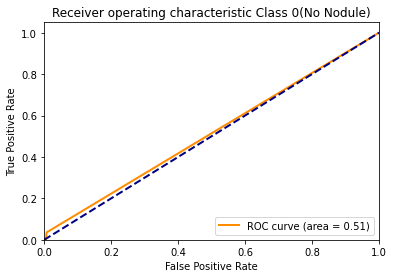

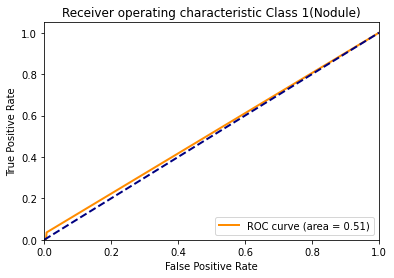

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 2
y_true_list = np.array(y_true_list).ravel()
y_prob_list = np.array(y_prob_list).ravel()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_list, y_prob_list)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_list, y_prob_list)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Class 0(No Nodule)')
plt.legend(loc="lower right")
plt.show()



plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Class 1(Nodule)')
plt.legend(loc="lower right")
plt.show()